In [112]:
%matplotlib inline
import sys
BIN = '../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams') #configuration file to customize properties of matplotlib


In [113]:
from nn_utils import AE_big, AE_3D_200
from utils import plot_activations

In [114]:
#If GPUs can be used for tensor computation, use them
torch.cuda.is_available()
#fastai.torch_core.defaults.device = 'cuda'

False

In [115]:
# Load data, show first 10 values by index
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')
# n_features = len(train.loc[0])

# train = train.sort_index(axis=0)

train.head(10)

,m,pt,phi,eta
0,23883.824219,228545.531250,2.711860,-1.438315
1,18192.466797,198106.546875,-0.421546,-0.439318
2,4526.073730,23818.916016,1.463485,-1.322502
4,4280.812988,22399.556641,-2.578426,2.959124
5,4888.467285,21843.285156,3.000935,-0.696199
6,18788.550781,161519.875000,-2.412254,0.423949
7,9975.544922,104593.726562,0.604990,-1.426898
8,5629.419922,26047.089844,-2.104888,-1.252906
9,5155.342285,24799.857422,1.141703,-0.259386
10,4408.627441,24017.154297,-3.102041,0.607402


In [116]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

In [117]:
def get_data(train_ds, valid_ds, bs):
    '''Samples given batch size(bs and 2*bs repectively) from training and validation data'''
    
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [118]:
#Create a database from the data for the model to train on
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)
db = basic_data.DataBunch(train_dl, valid_dl)

In [119]:
#chose the model parameters, many options availaible in ../nn_utils.py
model = AE_3D_200()
#chose the training loss function
loss_func = nn.MSELoss()

In [120]:
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6 #set weight decay (regularisation)

model.double()
# Trainer for model using data to minimize loss_func
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


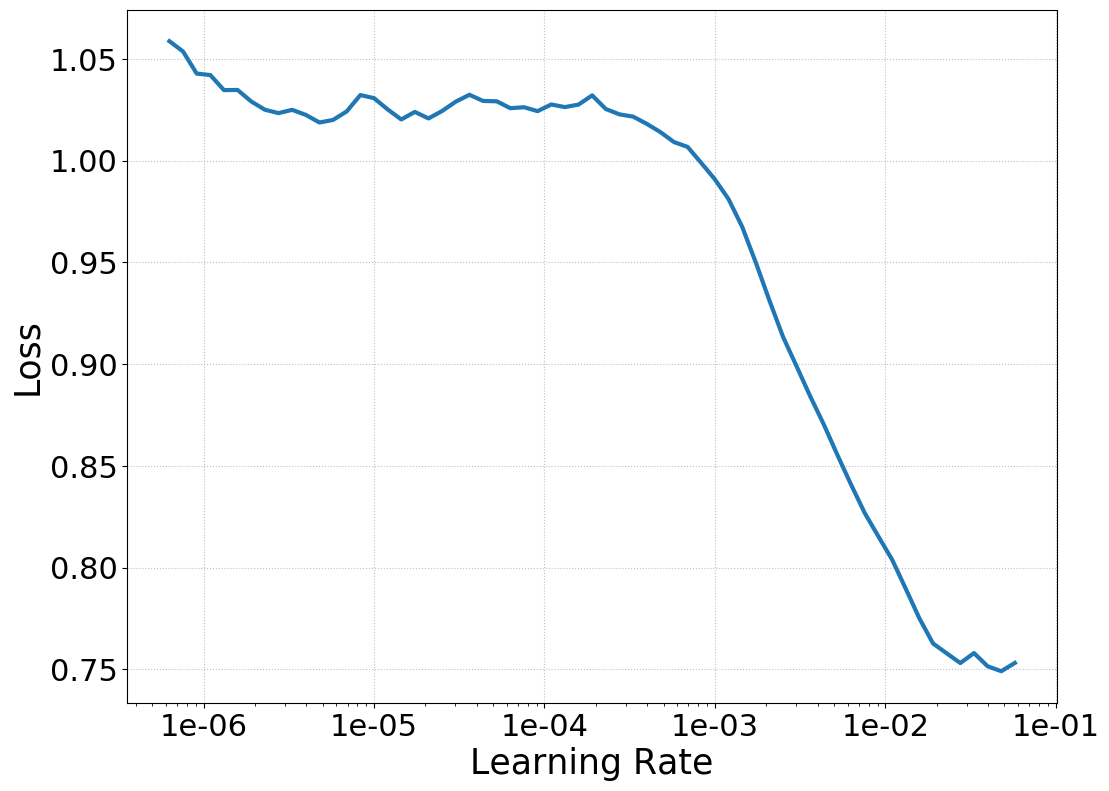

In [121]:
#finding learning rate for the trainer, visualize it in a graph
from fastai import train as tr
tr.lr_find(learn)
learn.recorder.plot()

In [122]:
#to see train/validation loss with iniltialised parameters
lr = 1e-7
learn.fit(1, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.998028,1.022784,00:15


epoch,train_loss,valid_loss,time
0,0.049521,0.046181,00:15
1,0.033334,0.036402,00:17
2,0.031703,0.034848,00:16
3,0.031937,0.034107,00:15
4,0.031721,0.033488,00:16
5,0.030329,0.032804,00:15
6,0.031873,0.032335,00:15
7,0.029416,0.031672,00:15
8,0.029781,0.031415,00:15
9,0.029527,0.031074,00:15


<Figure size 1200x900 with 0 Axes>

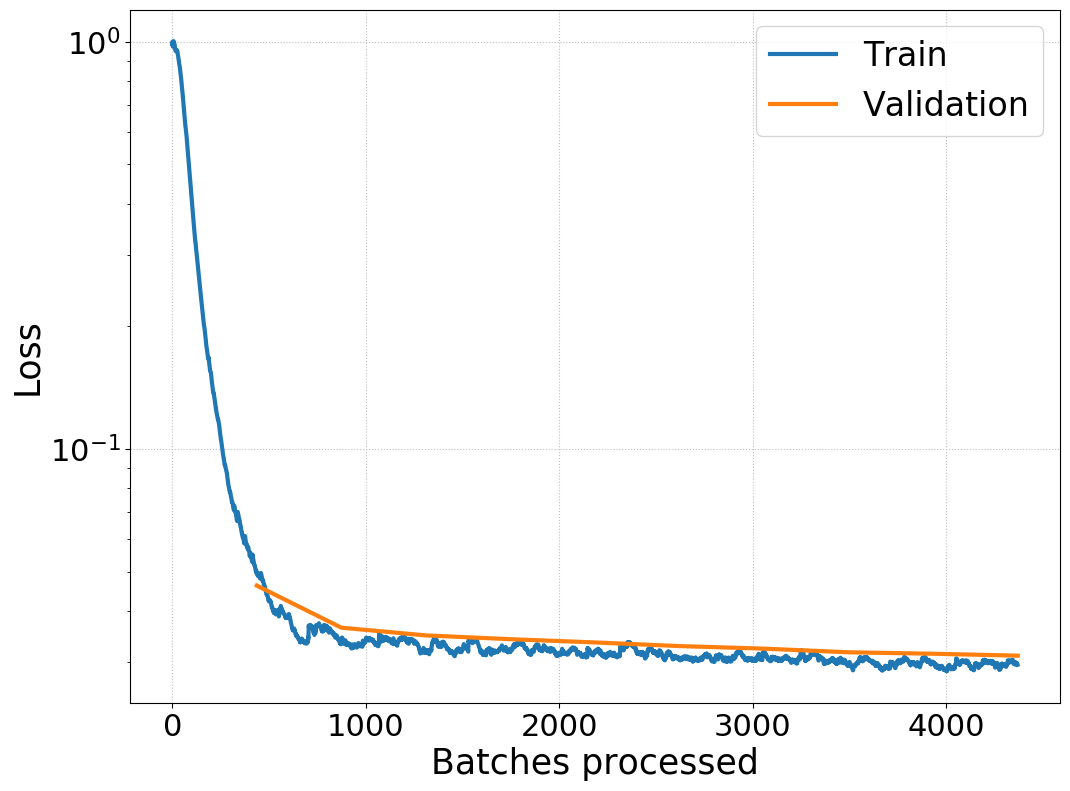

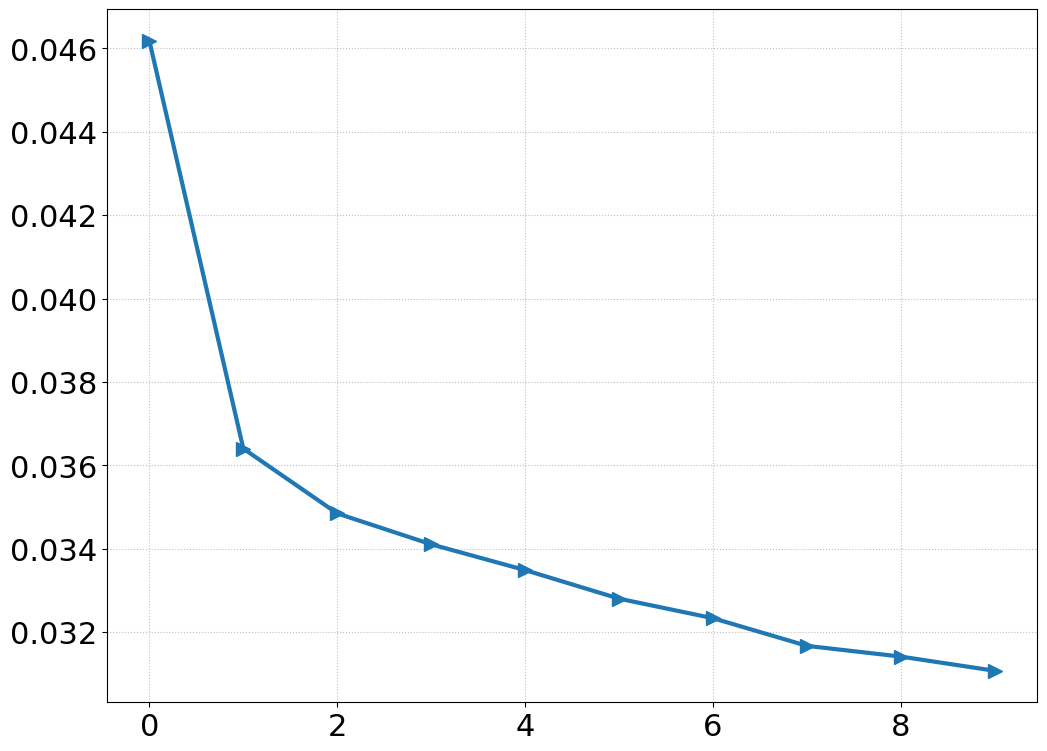

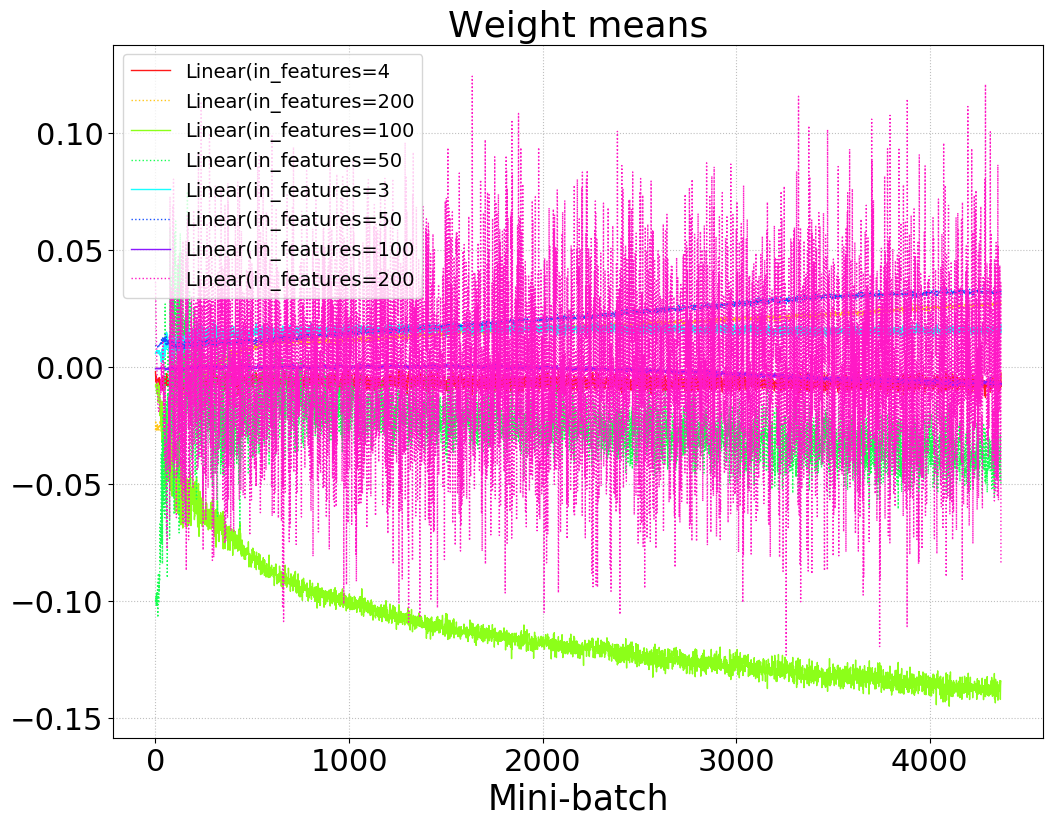

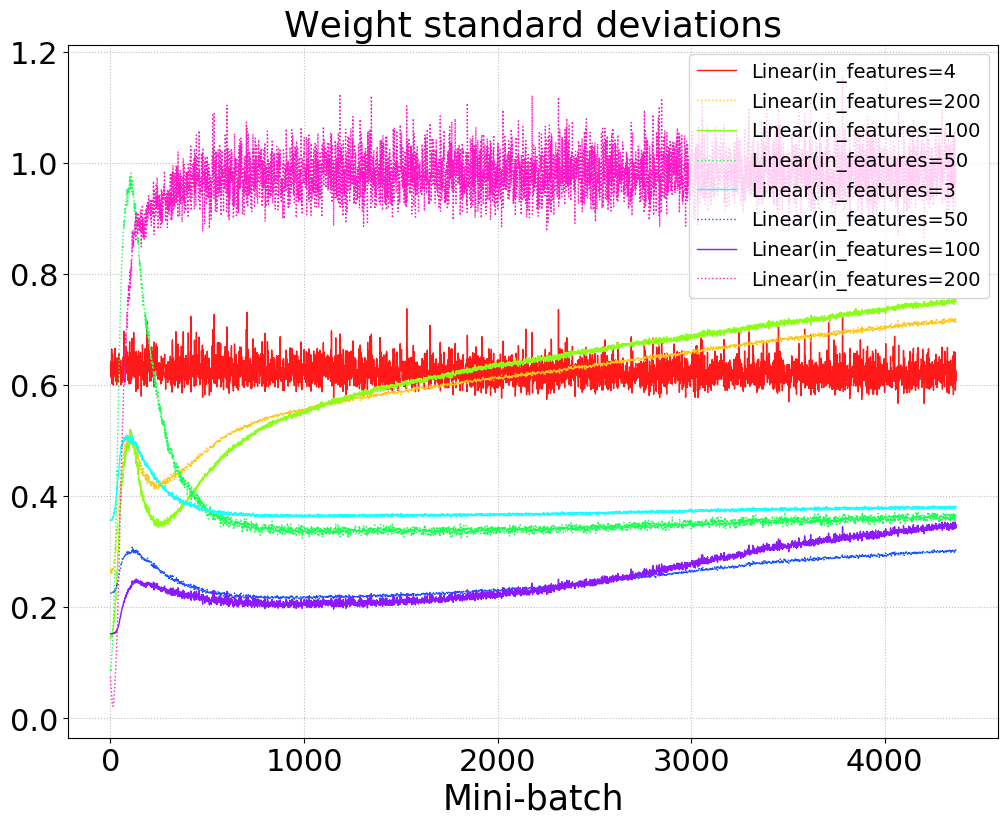

In [123]:
#begin model training: loss decreases at 1e-4 from above graph so this lr is okay to use (may not be optimal)
lr = 1e-4
learn.fit(10, lr=lr, wd=wd)
plt.figure()
learn.recorder.plot_losses()
plt.yscale('log')
plt.figure()
plt.plot(learn.recorder.val_losses, marker='>')
plot_activations(learn)

epoch,train_loss,valid_loss,time
0,0.027780,0.029855,00:15
1,0.025595,0.026004,00:16
2,0.022759,0.023273,00:15
3,0.022306,0.021390,00:15
4,0.020879,0.021536,00:15
5,0.019378,0.020570,00:16
6,0.019332,0.019040,00:15
7,0.019396,0.020424,00:15
8,0.017390,0.018781,00:15
9,0.018405,0.017999,00:16


<Figure size 1200x900 with 0 Axes>

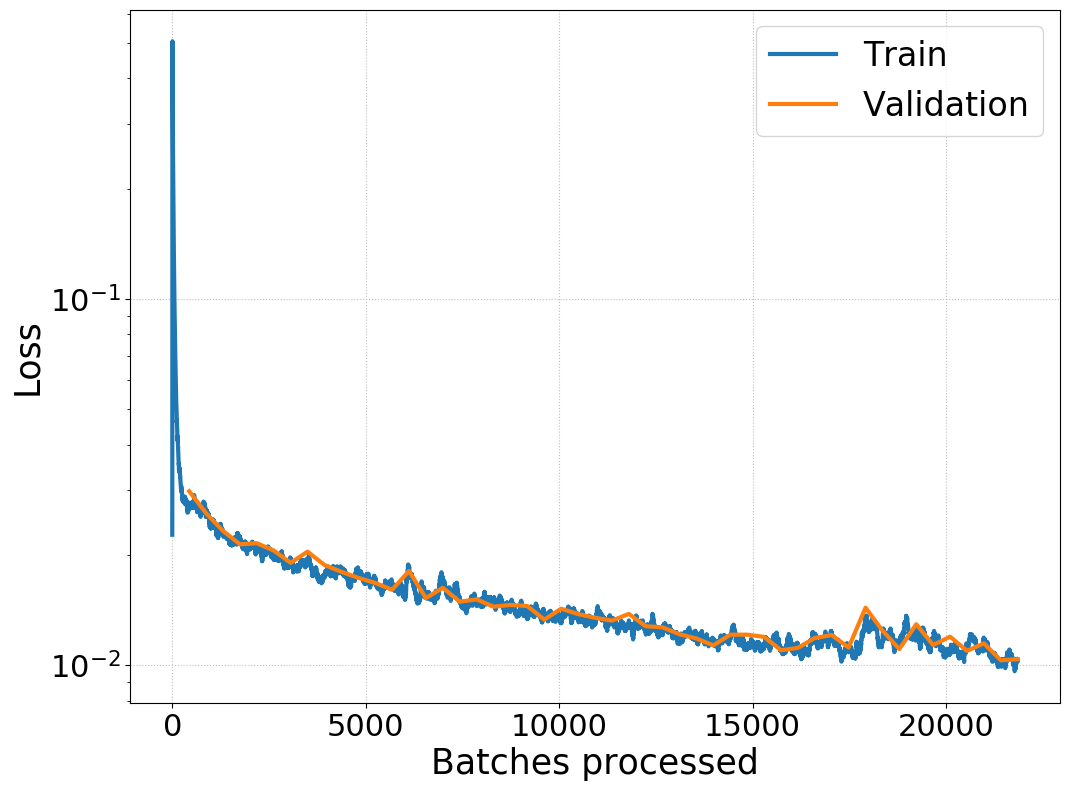

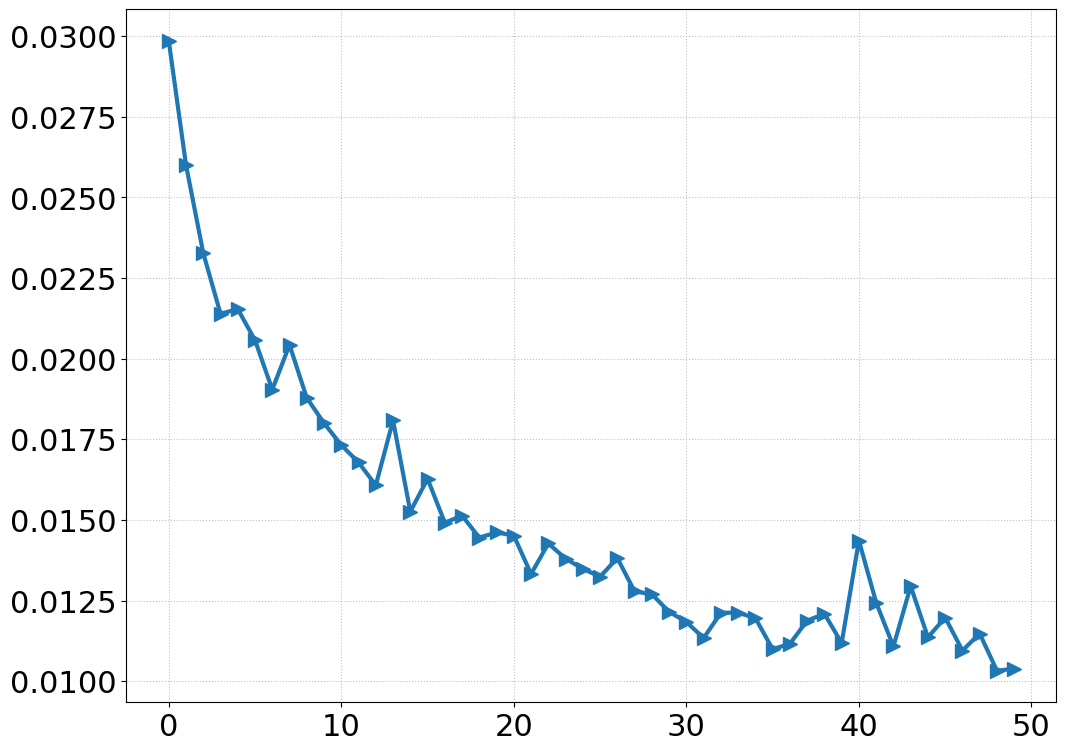

In [125]:
#as model converges fast for above 10 iterations increase lr and repeat
lr = 1e-3
learn.fit(50, lr=lr, wd=wd)
plt.figure()
learn.recorder.plot_losses()
plt.yscale('log')
plt.figure()
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

epoch,train_loss,valid_loss,time
0,0.010948,0.012234,00:15
1,0.010385,0.010989,00:15
2,0.011050,0.011302,00:15
3,0.011655,0.011352,00:15
4,0.011124,0.010406,00:15
5,0.010567,0.010236,00:15
6,0.009512,0.010698,00:15
7,0.010493,0.010295,00:16
8,0.010399,0.010603,00:15
9,0.010542,0.010378,00:16


<Figure size 1200x900 with 0 Axes>

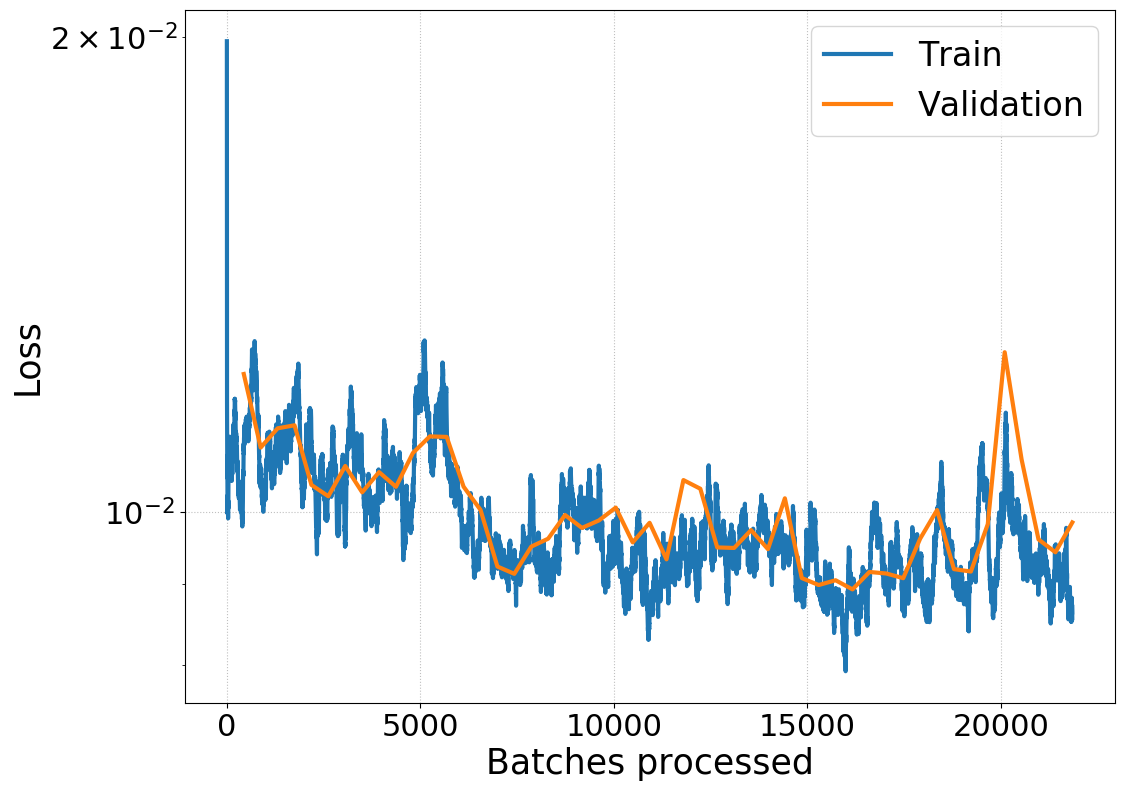

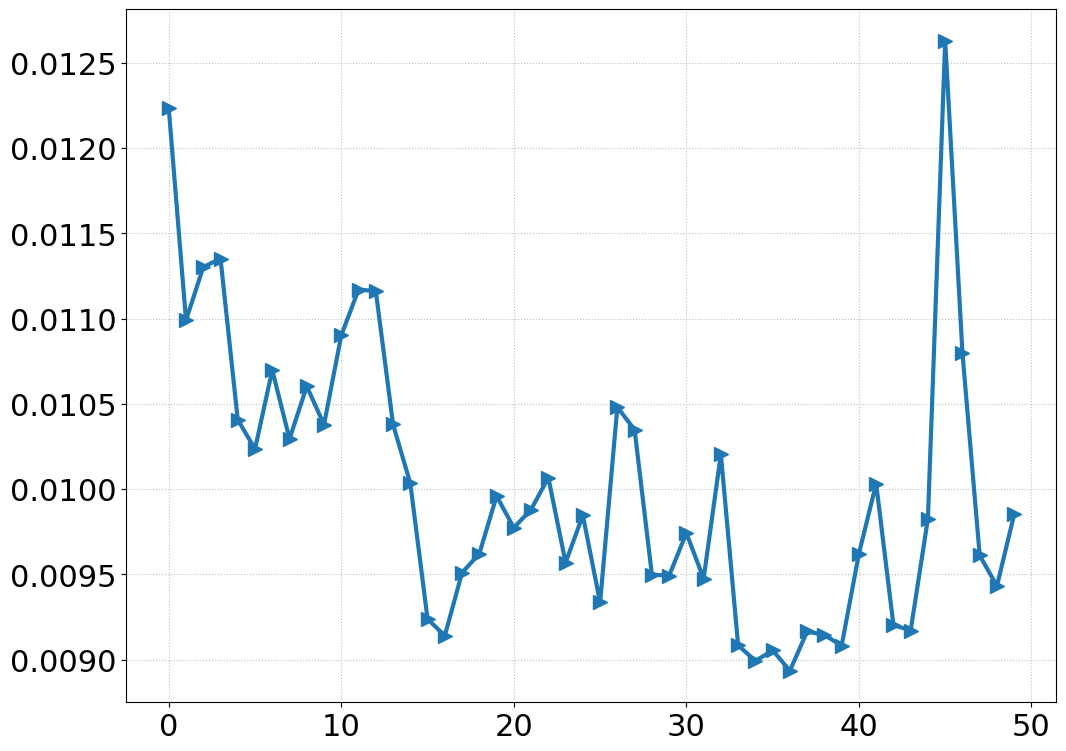

In [126]:
#as model converges fast for above 50 iterations increase lr and repeat
lr = 1e-3
learn.fit(50, lr=lr, wd=wd)
plt.figure()
learn.recorder.plot_losses()
plt.yscale('log')
plt.figure()
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

epoch,train_loss,valid_loss,time
0,0.007958,0.007815,00:17
1,0.007663,0.008255,00:16
2,0.007377,0.007633,00:15
3,0.007633,0.007735,00:16
4,0.007175,0.007851,00:16
5,0.007285,0.007909,00:17
6,0.007525,0.007583,00:16
7,0.007518,0.007649,00:16
8,0.007526,0.007227,00:16
9,0.007291,0.007648,00:16


<Figure size 1200x900 with 0 Axes>

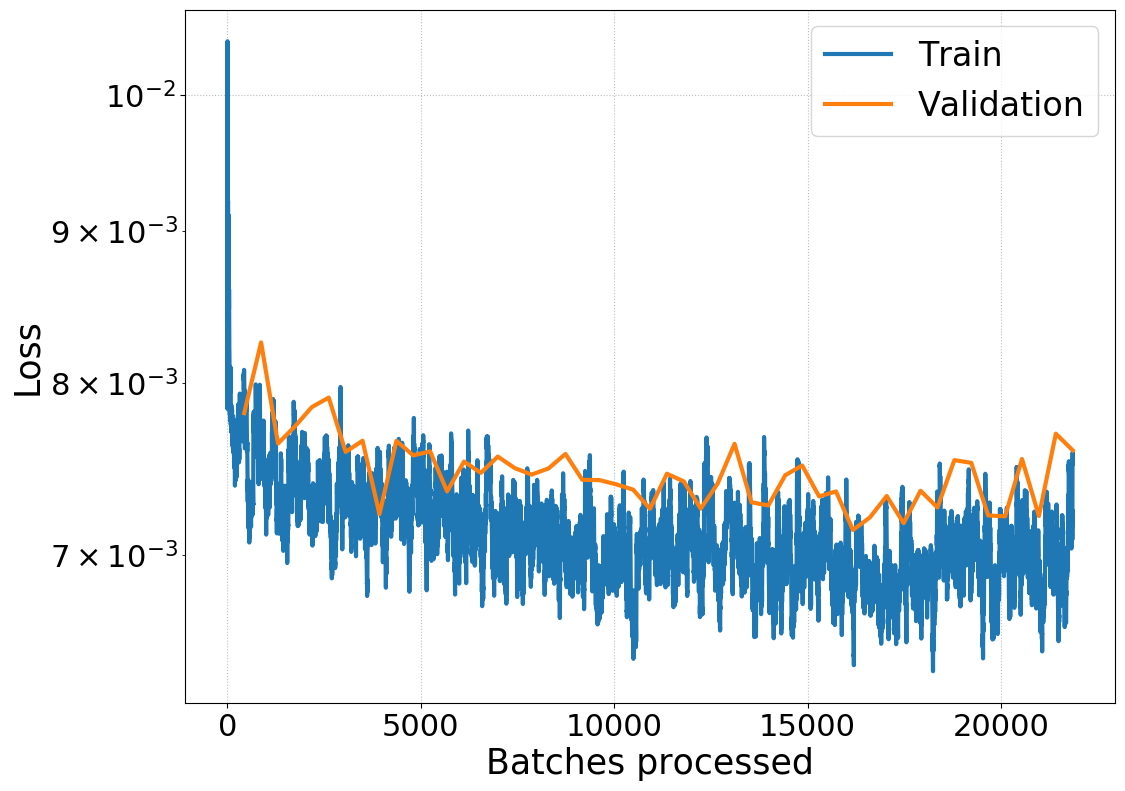

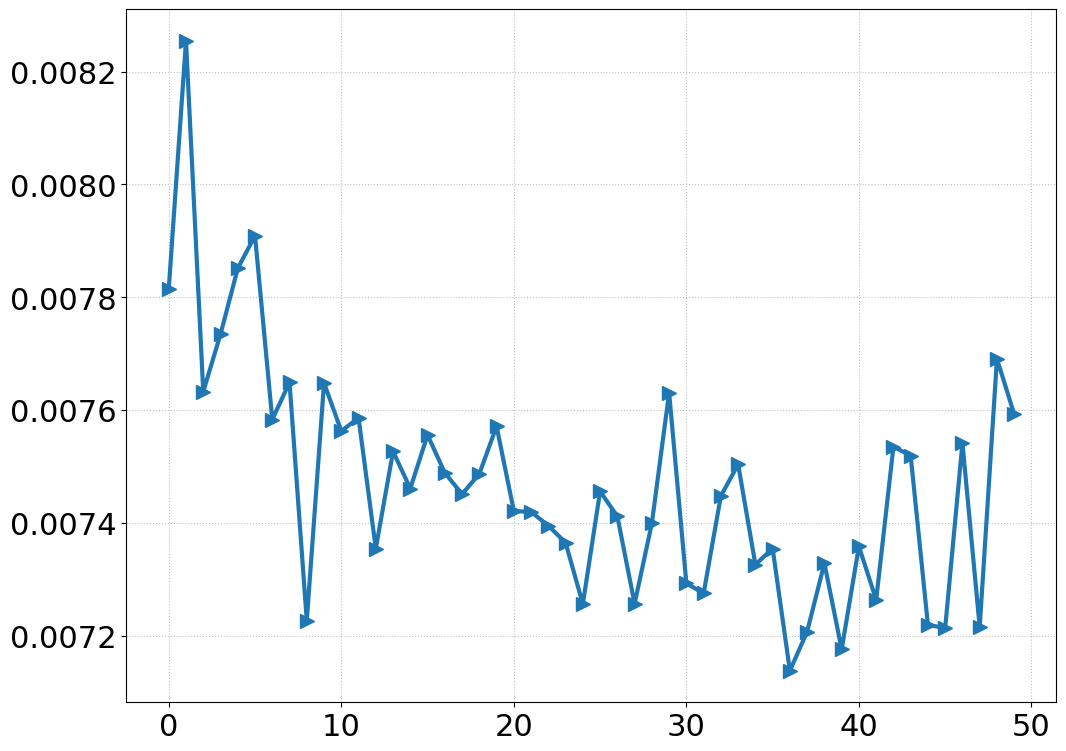

In [127]:
#model convergence goes slower hence decrease lr and repeat
lr = 1e-4
learn.fit(50, lr=lr, wd=wd)
plt.figure()
learn.recorder.plot_losses()
plt.yscale('log')
plt.figure()
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

epoch,train_loss,valid_loss,time
0,0.007045,0.007724,00:16
1,0.007089,0.007530,00:16
2,0.007125,0.007746,00:15
3,0.007050,0.007713,00:15
4,0.007111,0.007787,00:15


<Figure size 1200x900 with 0 Axes>

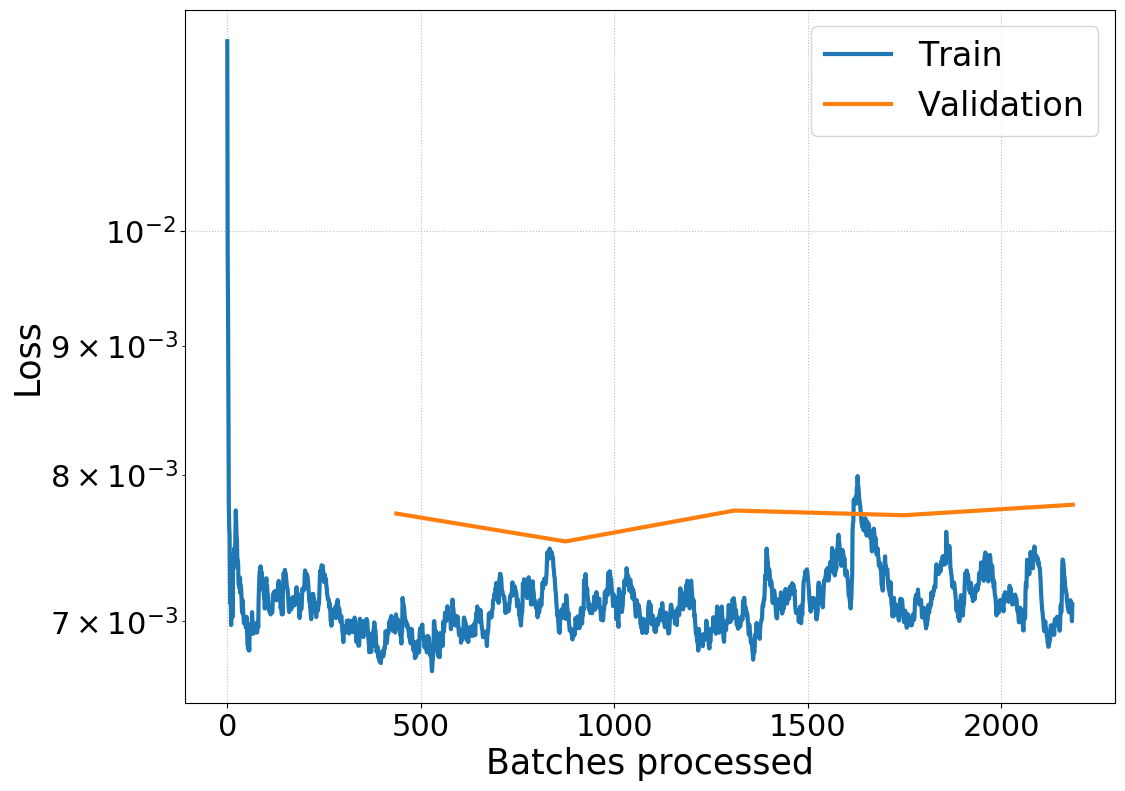

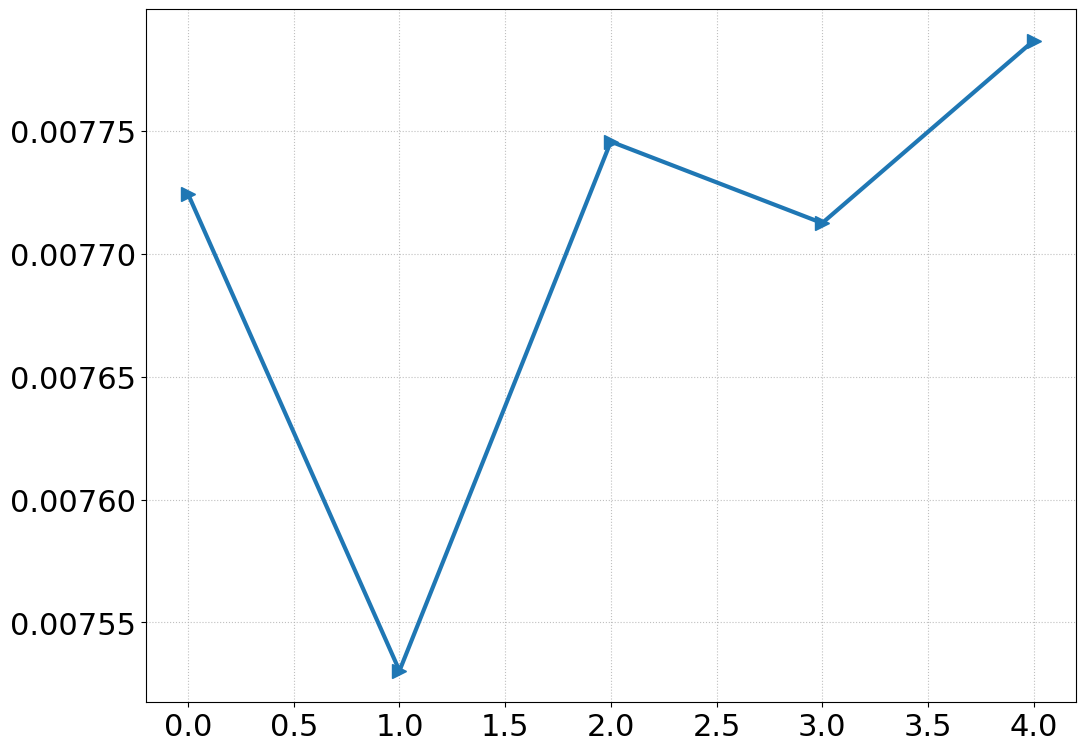

In [128]:
lr = 1e-4
learn.fit(5, lr=lr, wd=wd)
plt.figure()
learn.recorder.plot_losses()
plt.yscale('log')
plt.figure()
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

epoch,train_loss,valid_loss,time
0,0.007507,0.007756,00:15
1,0.007026,0.007625,00:15
2,0.006995,0.007614,00:15
3,0.006837,0.007592,00:16
4,0.007067,0.007630,00:15
5,0.007070,0.007616,00:16
6,0.006522,0.007595,00:15
7,0.007194,0.007550,00:15
8,0.007017,0.007556,00:15
9,0.006686,0.007535,00:15


<Figure size 1200x900 with 0 Axes>

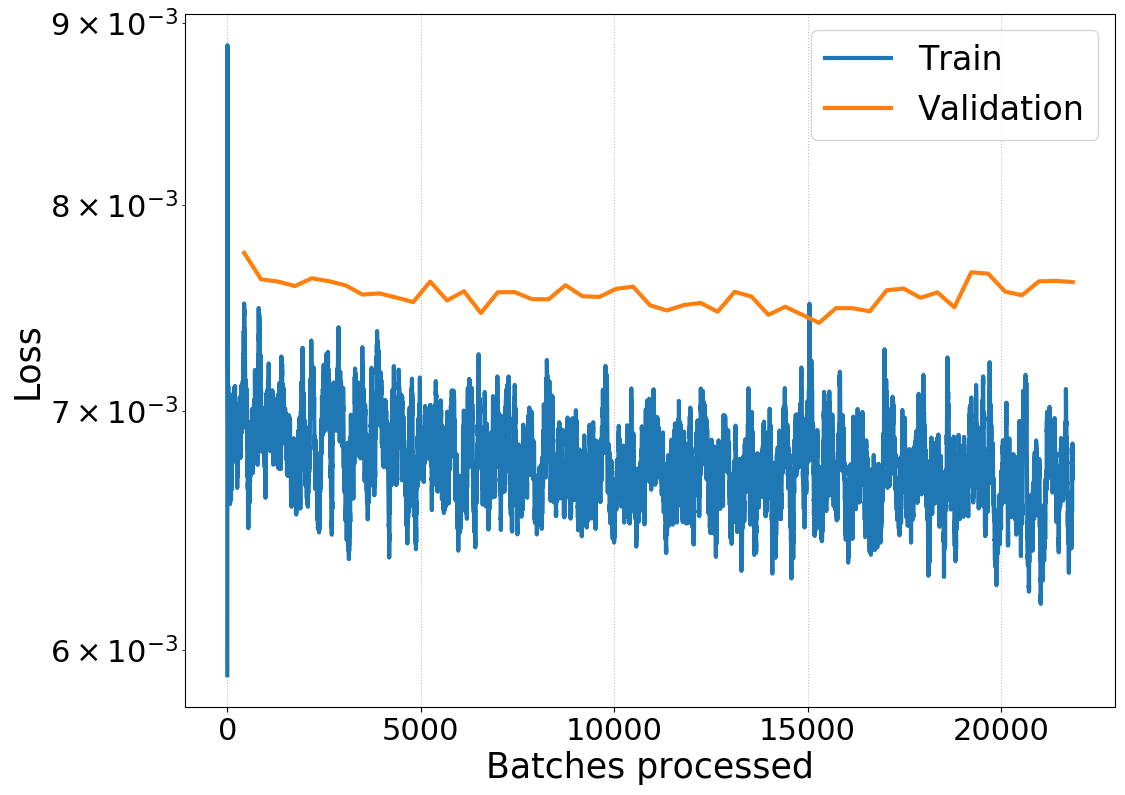

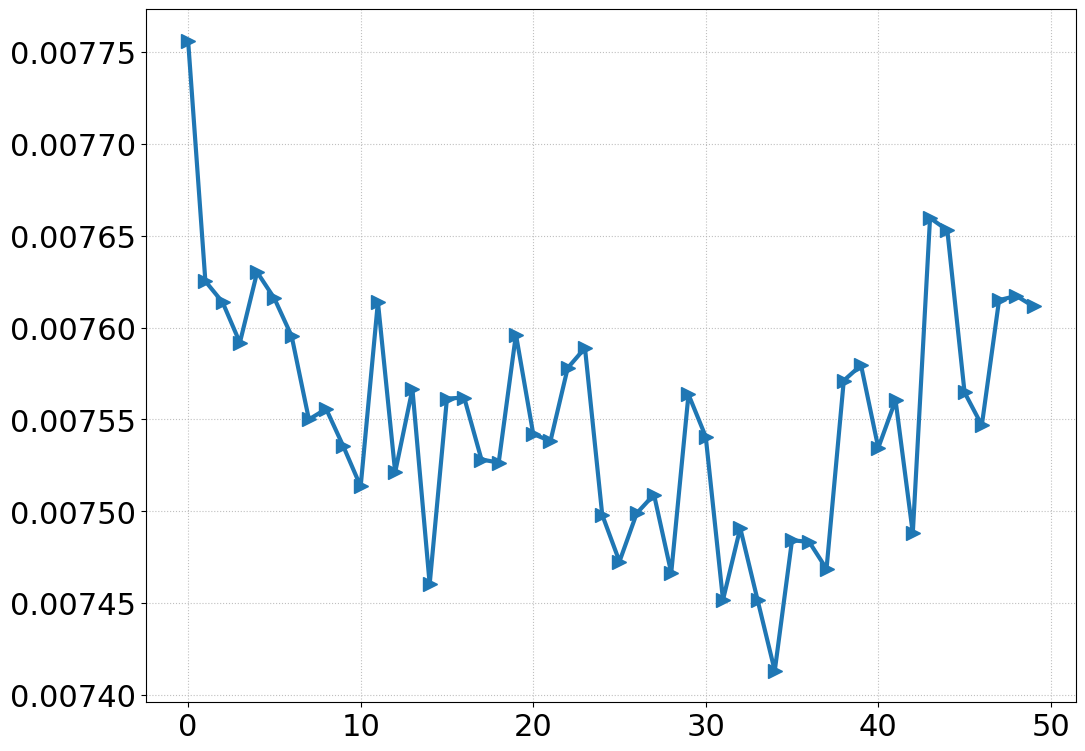

In [129]:
#model convergence goes slower hence decrease lr and repeat
lr = 1e-5
learn.fit(50, lr=lr, wd=wd)
plt.figure()
learn.recorder.plot_losses()
plt.yscale('log')
plt.figure()
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

epoch,train_loss,valid_loss,time
0,0.006566,0.007196,00:15
1,0.006778,0.007171,00:15
2,0.006949,0.007160,00:15
3,0.006614,0.007158,00:16
4,0.006349,0.007148,00:15
5,0.006614,0.007138,00:15
6,0.006521,0.007134,00:16
7,0.006584,0.007130,00:15
8,0.006729,0.007120,00:15
9,0.006737,0.007120,00:16


<Figure size 1200x900 with 0 Axes>

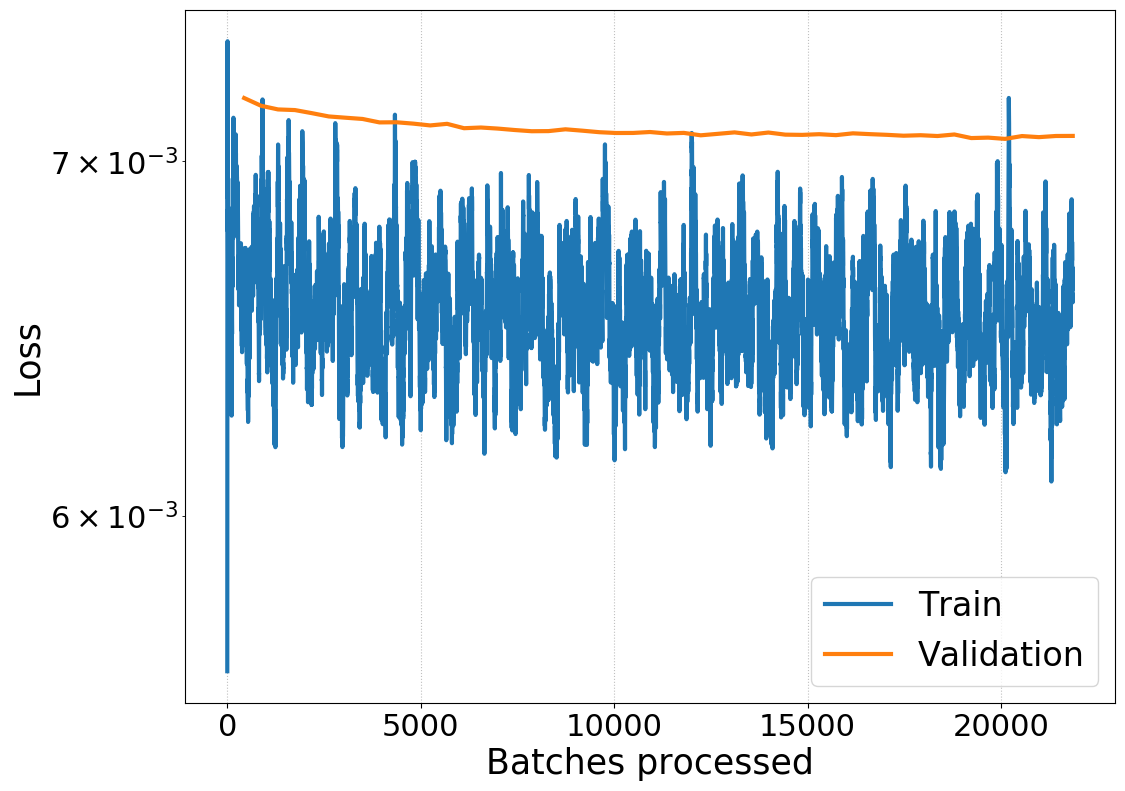

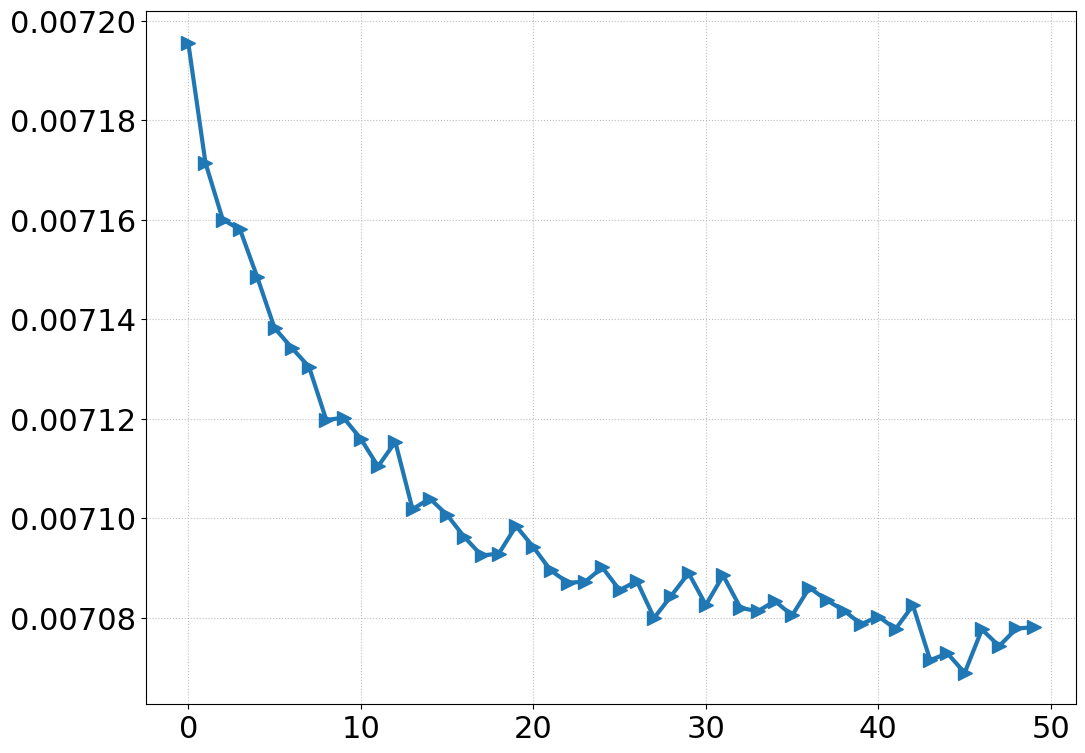

In [131]:
#model has appeared to converged, verify for a small enough lr
lr = 1e-6
learn.fit(50, lr=lr, wd=wd)
plt.figure()
learn.recorder.plot_losses()
plt.yscale('log')
plt.figure()
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [134]:
#model has appeared to converged, verify for a small enough lr
lr = 1e-5
learn.fit(1000, lr=lr, wd=wd)
learn.recorder.plot_losses()
plt.yscale('log')
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

epoch,train_loss,valid_loss,time
0,0.006541,0.007392,00:11
1,0.006516,0.007241,00:10
2,0.006318,0.007357,00:09
3,0.006699,0.007400,00:12
4,0.006296,0.007241,00:10
5,0.006432,0.007358,00:10
6,0.006666,0.007323,00:09
7,0.006578,0.007369,00:09
8,0.006464,0.007314,00:07
9,0.006280,0.007397,00:08


KeyboardInterrupt: 

In [135]:
#save the model for analysis
learn.save('AE_3D_200_no1cycle_trainforever')

In [166]:
curr_save_folder = 'trainforever_plots/'

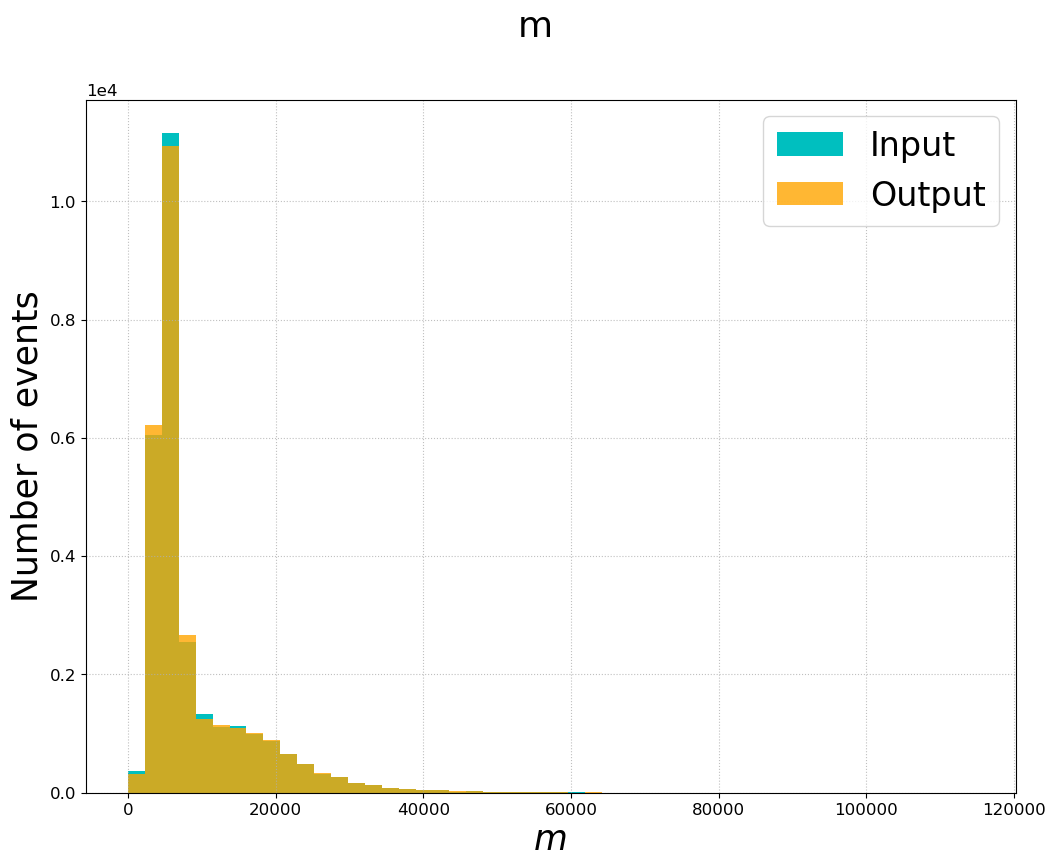

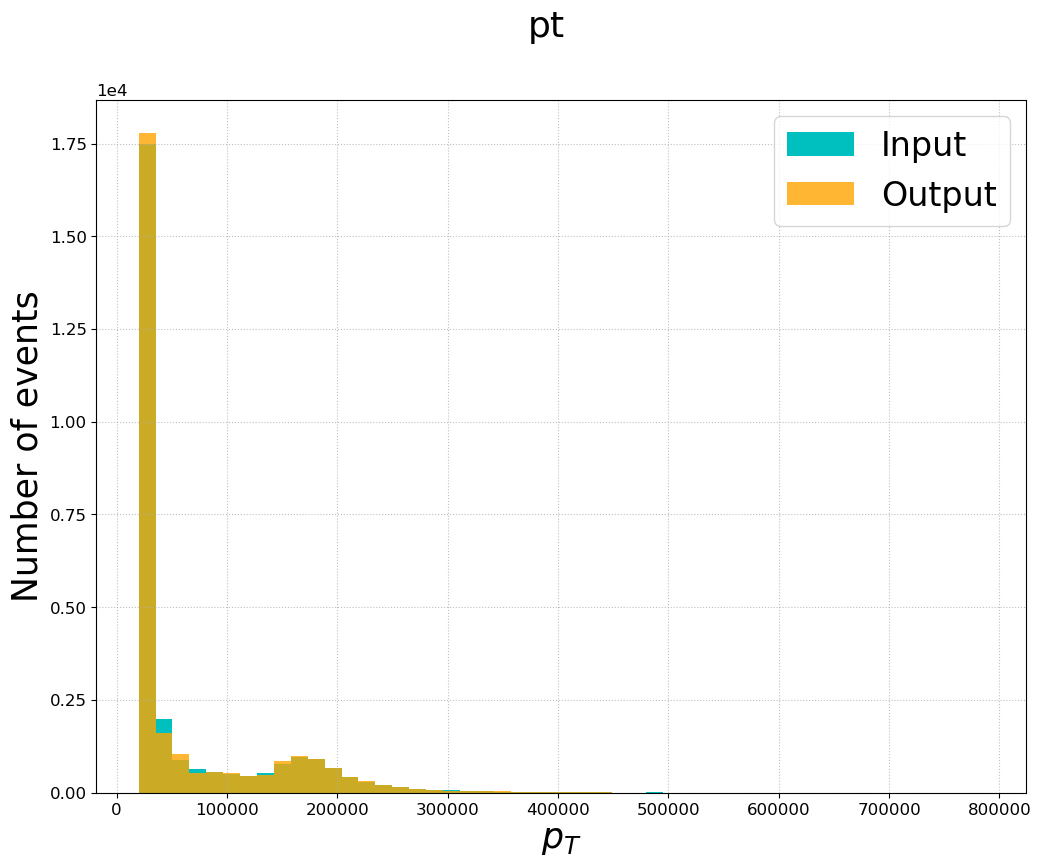

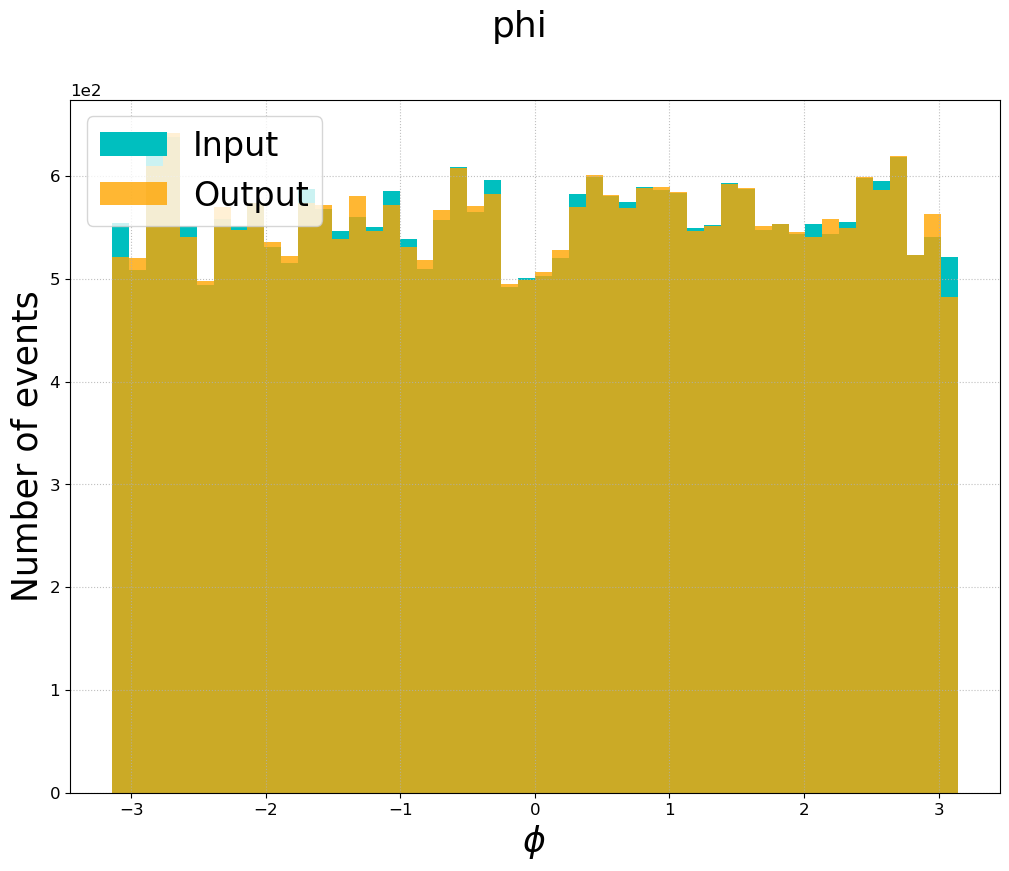

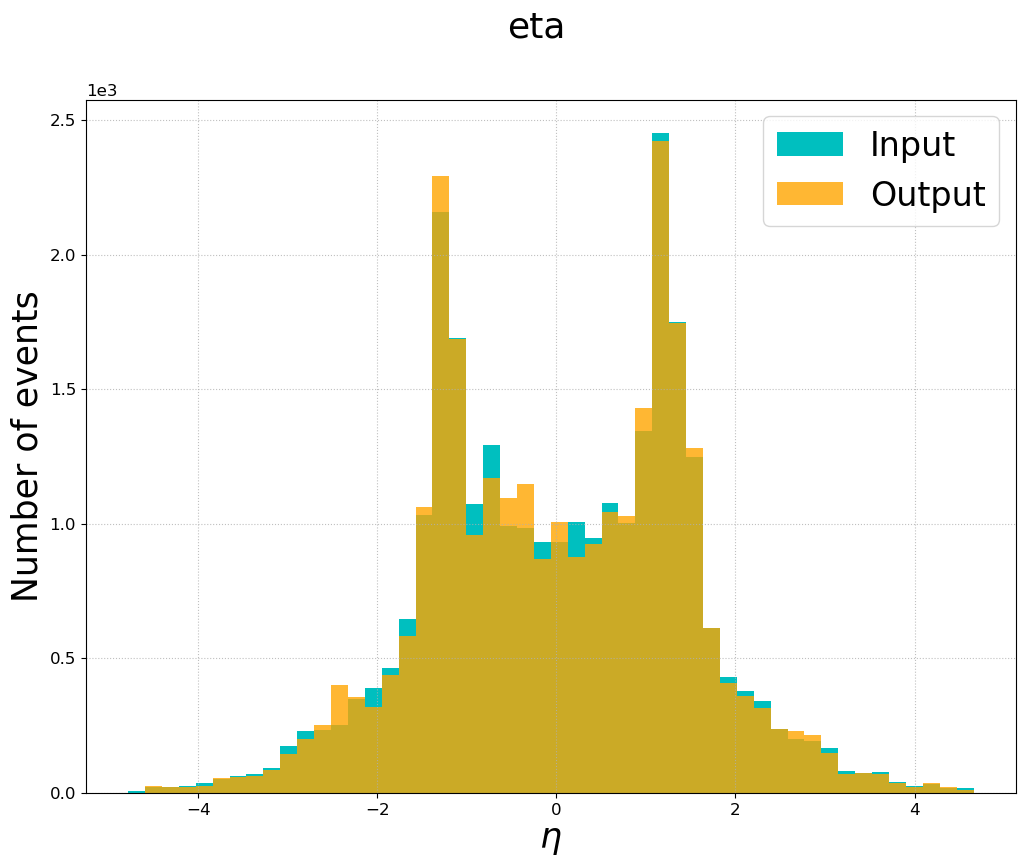

In [167]:
#plotting the input and output on top of each other, for each parameter, as histograms
#only one color(mixture of the two) will be visible when these overlap. We want maximum overlap
plt.close('all')
unit_list = ['', '', '', '']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


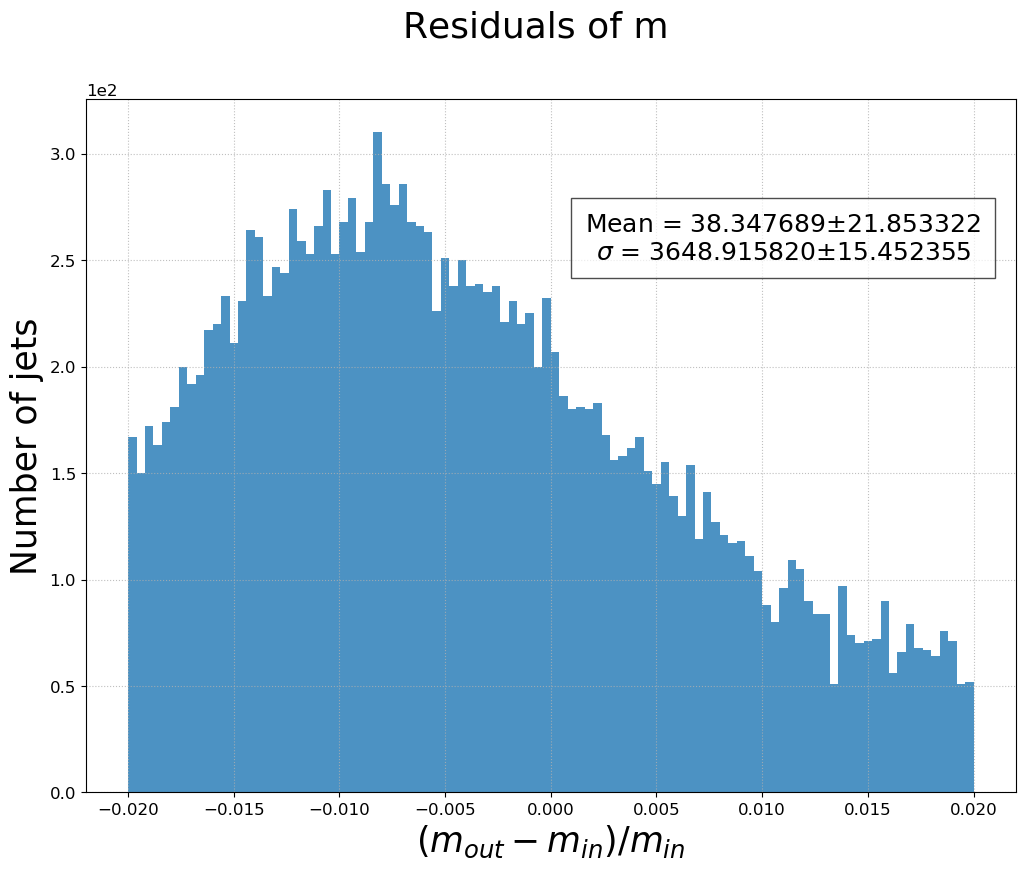

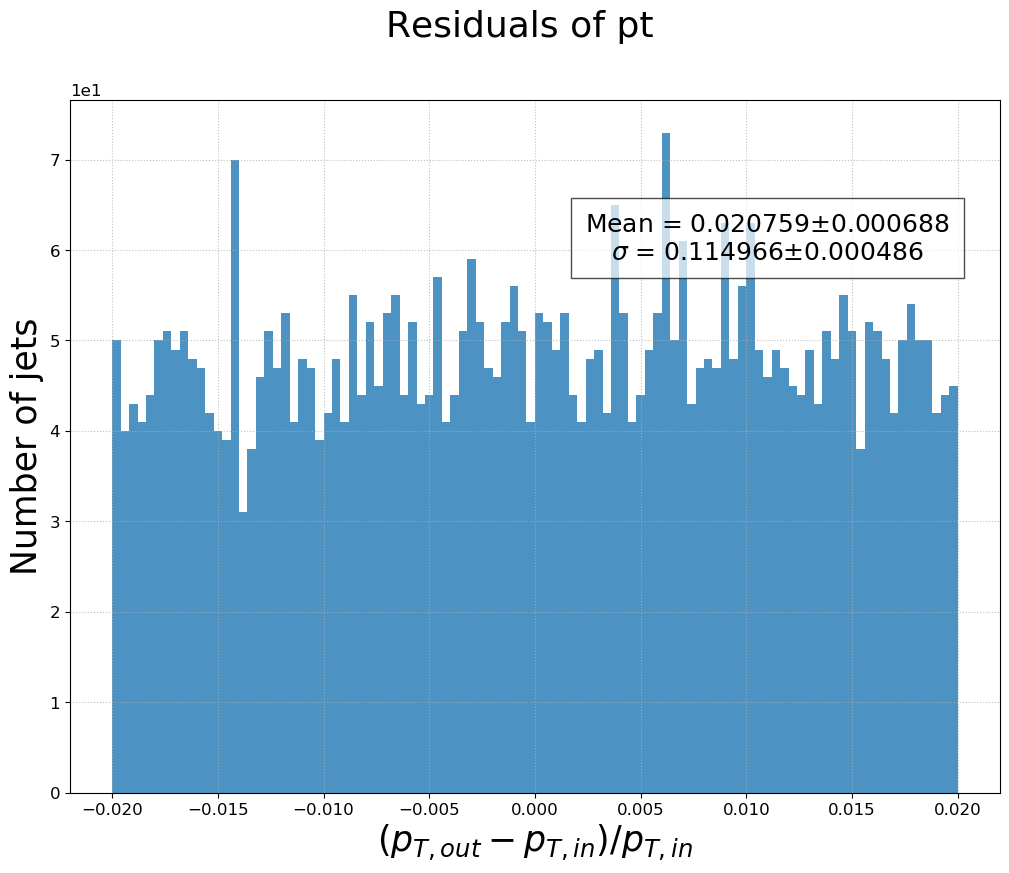

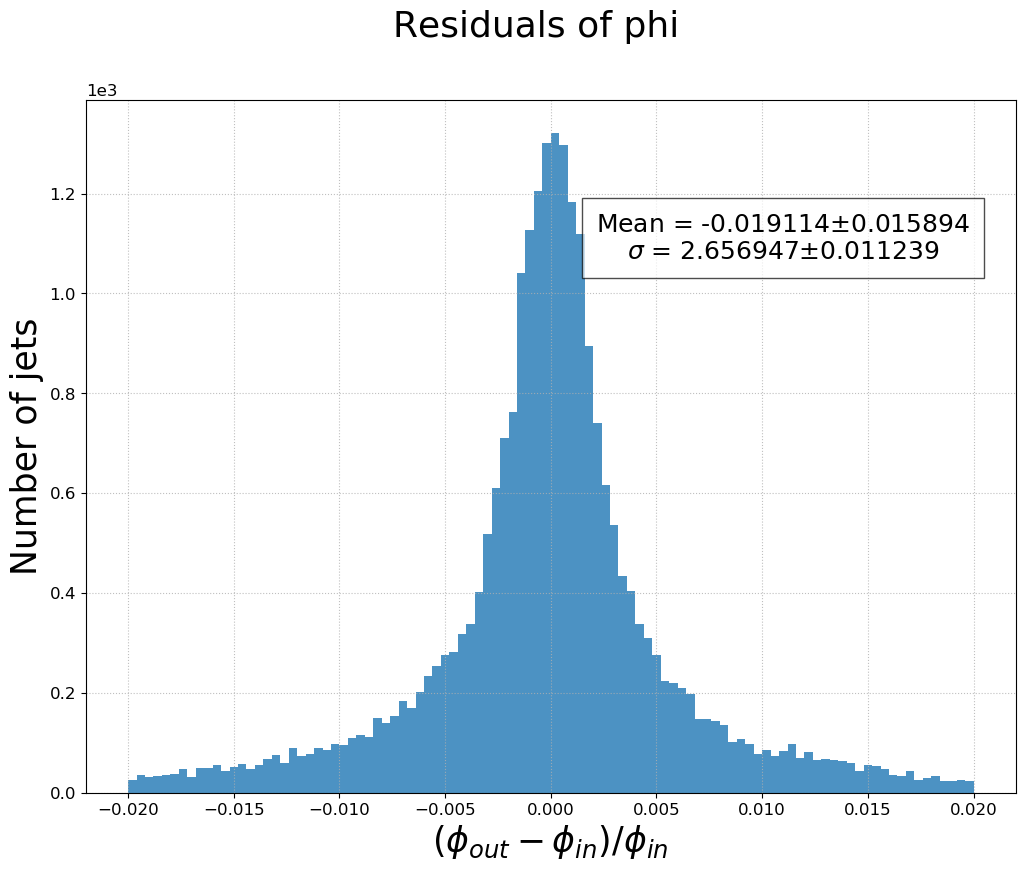

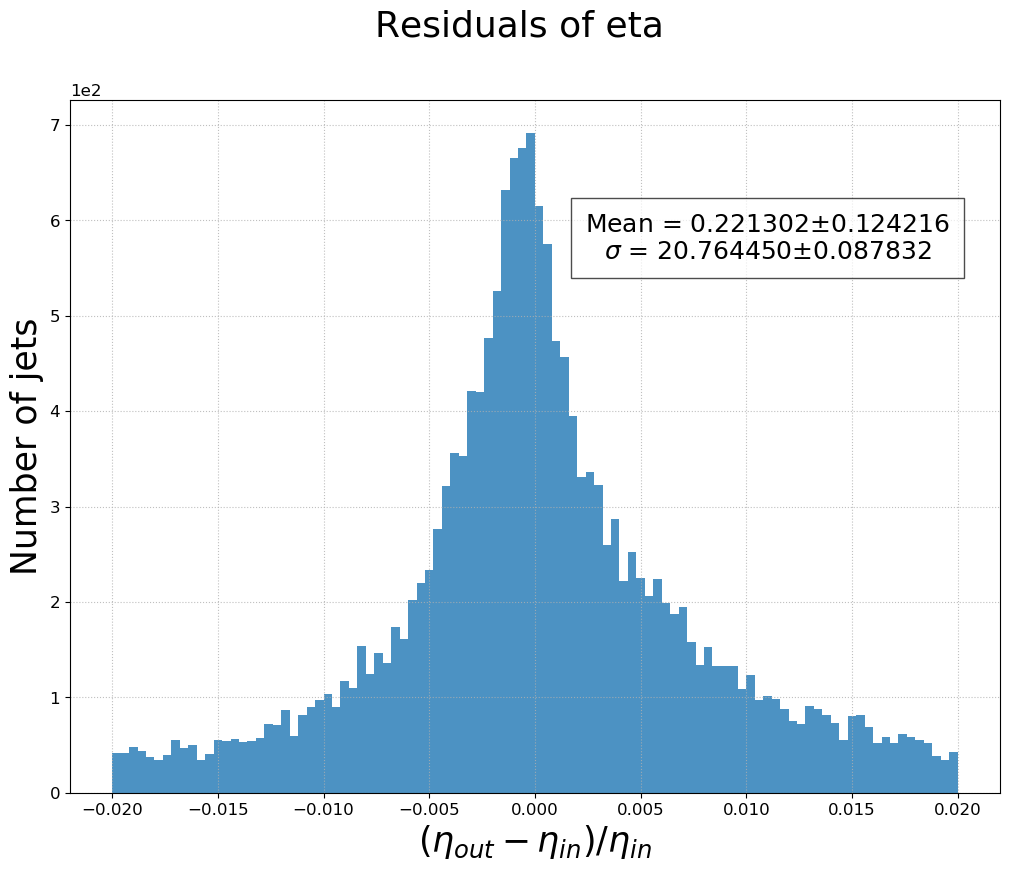

In [212]:
#residuals distributions' plotted, most of them should have mean very close to zero and low standard deviation is desirable 
import utils
from scipy import stats
residual_strings = [r'$(m_{out} - m_{in}) / m_{in}$',
                        r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$']
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
range = (-.02, .02)

#values corresponding to where m is zero (residual is infinity) are ignored for visualization purpose

for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.nanstd(residuals[:, kk][~np.isinf(residuals[:,kk])])
    std_err = utils.std_error(residuals[:, kk][~np.isinf(residuals[:,kk])])
    mean = np.nanmean(residuals[:, kk][~np.isinf(residuals[:,kk])])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)